In [16]:
# %%
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# %%
# ====================================================
name = "/content/Kraken_BTCUSD_60_3Q2022.csv"
df = pd.read_csv(name)

df["unix"] = pd.to_numeric(df["unix"])
df["date"] = pd.to_datetime(df["unix"], unit="s")

In [17]:
df = df[["date", "close", "volume", "trades"]]

In [18]:
df.head ()

,date,close,volume,trades
0,2013-10-06 21:00:00,122.00,0.1000,1
1,2013-10-07 20:00:00,123.61,0.1000,1
2,2013-10-08 02:00:00,123.90,1.9916,2
3,2013-10-08 05:00:00,124.18,2.0000,2
4,2013-10-09 09:00:00,123.84,2.8230,3


In [19]:
df["Ret"] = df["close"].pct_change()
df["year"] = df["date"].dt.year

In [20]:
df.tail ()

,date,close,volume,trades,Ret,year
67886,2022-09-30 19:00:00,19497.2,290.023381,1947,-0.008941,2022
67887,2022-09-30 20:00:00,19420.4,759.074836,1648,-0.003939,2022
67888,2022-09-30 21:00:00,19360.4,564.894247,1245,-0.003090,2022
67889,2022-09-30 22:00:00,19387.1,90.626135,1978,0.001379,2022
67890,2022-09-30 23:00:00,19425.2,57.986112,2466,0.001965,2022


In [21]:
del df["close"]
df = df.loc[(df["year"] >= 2020)]
df.head()

,date,volume,trades,Ret,year
43802,2020-01-01 00:00:00,70.761775,267,-0.001758,2020
43803,2020-01-01 01:00:00,224.921206,528,0.005408,2020
43804,2020-01-01 02:00:00,138.910528,336,0.003906,2020
43805,2020-01-01 03:00:00,97.687456,240,-0.002908,2020
43806,2020-01-01 04:00:00,25.305555,131,-0.001236,2020


In [22]:
df = df.reindex(
    columns=[
        "date",
        "Ret",
        "volume",
        "trades",
        "year",
        "month",
        "day",
        "week",
        "weekday",
        "hour",
    ]
)
df = df[["date", "Ret"]]

n_lags = 24 * 15

for i in range(1, n_lags + 1):
    name = "Ret_" + str(i)
    df[name] = df["Ret"].shift(i)

df["Ret4_i"] = df["Ret"].rolling(4).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret4"] = df["Ret4_i"].shift(-4)
df["Output"] = df["Ret4"] > 0
df["Output"] = df["Output"].astype(int)
del df["Ret4"]
del df["Ret4_i"]

df = df.dropna()

df.head()


,date,Ret,Ret_1,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,...,Ret_352,Ret_353,Ret_354,Ret_355,Ret_356,Ret_357,Ret_358,Ret_359,Ret_360,Output
44162,2020-01-16 00:00:00,-0.006651,-0.003923,0.002289,0.001885,0.006651,0.001603,-0.004581,0.000353,0.003385,...,-0.001016,-0.001833,0.000751,0.000209,-0.001236,-0.002908,0.003906,0.005408,-0.001758,0
44163,2020-01-16 01:00:00,-0.011403,-0.006651,-0.003923,0.002289,0.001885,0.006651,0.001603,-0.004581,0.000353,...,-0.000822,-0.001016,-0.001833,0.000751,0.000209,-0.001236,-0.002908,0.003906,0.005408,1
44164,2020-01-16 02:00:00,-0.001248,-0.011403,-0.006651,-0.003923,0.002289,0.001885,0.006651,0.001603,-0.004581,...,0.001673,-0.000822,-0.001016,-0.001833,0.000751,0.000209,-0.001236,-0.002908,0.003906,1
44165,2020-01-16 03:00:00,-0.000347,-0.001248,-0.011403,-0.006651,-0.003923,0.002289,0.001885,0.006651,0.001603,...,-0.000710,0.001673,-0.000822,-0.001016,-0.001833,0.000751,0.000209,-0.001236,-0.002908,1
44166,2020-01-16 04:00:00,-0.000023,-0.000347,-0.001248,-0.011403,-0.006651,-0.003923,0.002289,0.001885,0.006651,...,0.003482,-0.000710,0.001673,-0.000822,-0.001016,-0.001833,0.000751,0.000209,-0.001236,1


In [23]:
X, y = df.iloc[:, 2:-1], df.iloc[:, -1]
print(X.shape, y.shape)

(23729, 360) (23729,)


In [24]:
hp_units = 85
hp_units_2 = 55
hp_units_3 = 30
n_dropout = 0.2
act_fun = "relu"

In [26]:
n_train = 5000
n_test = 1000

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = df.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}

    # Reset the index of y_train to avoid potential KeyError
    y_train = y_train.reset_index(drop=True)

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: ['2020-08-11T08:00:00.000000000']  -- end test ['2020-09-21T23:00:00.000000000']  -------  (5000, 360) (5000,) (1000, 360) (1000,) (1000, 1) (1000, 1)
ite  1.0  -- start test: ['2020-09-22T00:00:00.000000000']  -- end test ['2020-11-02T16:00:00.000000000']  -------  (5000, 360) (5000,) (1000, 360) (1000,) (1000, 1) (1000, 1)
ite  2.0  -- start test: ['2020-11-02T17:00:00.000000000']  -- end test ['2020-12-14T08:00:00.000000000']  -------  (5000, 360) (5000,) (1000, 360) (1000,) (1000, 1) (1000, 1)
ite  3.0  -- start test: ['2020-12-14T09:00:00.000000000']  -- end test ['2021-01-25T00:00:00.000000000']  -------  (5000, 360) (5000,) (1000, 360) (1000,) (1000, 1) (1000, 1)
ite  4.0  -- start test: ['2021-01-25T01:00:00.000000000']  -- end test ['2021-03-07T17:00:00.000000000']  -------  (5000, 360) (5000,) (1000, 360) (1000,) (1000, 1) (1000, 1)
ite  5.0  -- start test: ['2021-03-07T18:00:00.000000000']  -- end test ['2021-04-18T09:00:00.000000000']  -------  (500

In [27]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res.tail()

,Date,Pred,Ret
18724,2022-09-30 19:00:00,1.0,-0.008941
18725,2022-09-30 20:00:00,0.0,-0.003939
18726,2022-09-30 21:00:00,1.0,-0.003090
18727,2022-09-30 22:00:00,1.0,0.001379
18728,2022-09-30 23:00:00,0.0,0.001965


In [28]:
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

Strat Return Long Only = 76.55001093604403 %
Strat Return = 49.522370632391485 %
Buy and Hold Return = 65.15499328334393 %


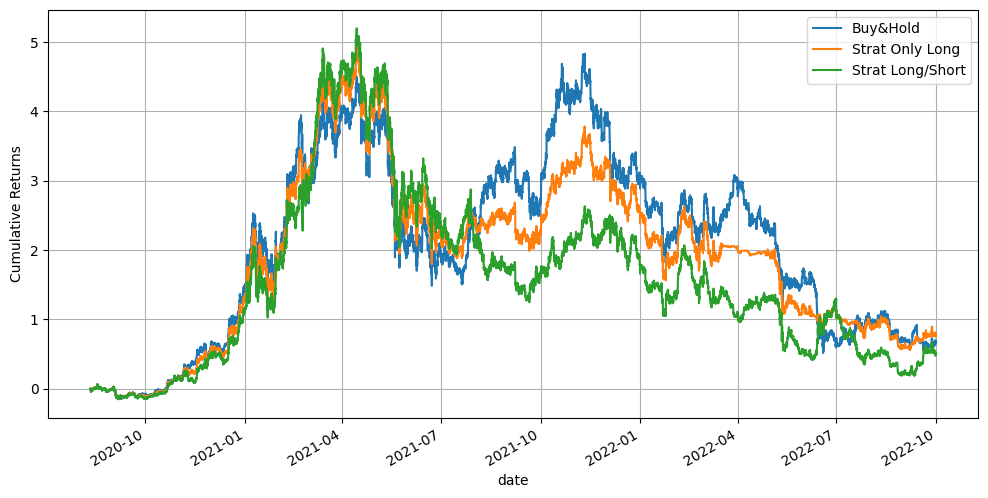

,Date,Pred,Ret,Positions,Positions_shift,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet,trade_bin
count,18729,18729.000000,18729.000000,18729.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18728.000000,18729.000000,18728.000000
mean,2021-09-05 16:28:15.338779648,0.777511,0.000060,0.555022,0.555105,0.000055,0.777552,0.000058,1.564581,1.886647,2.053200,0.206909
min,2020-08-11 08:00:00,0.000000,-0.121059,-1.000000,-1.000000,-0.121059,0.000000,-0.121059,-0.152718,-0.151243,-0.154755,0.000000
25%,2021-02-22 12:00:00,1.000000,-0.003351,1.000000,1.000000,-0.003315,1.000000,-0.002181,0.519259,0.911442,0.821464,0.000000
50%,2021-09-05 19:00:00,1.000000,0.000090,1.000000,1.000000,0.000083,1.000000,-0.000000,1.420691,1.992726,2.209577,0.000000
75%,2022-03-19 21:00:00,1.000000,0.003556,1.000000,1.000000,0.003593,1.000000,0.002433,2.181784,2.593754,3.033303,0.000000
max,2022-09-30 23:00:00,1.000000,0.124064,1.000000,1.000000,0.124064,1.000000,0.124064,5.197890,4.952039,4.832441,1.000000
std,NaN,0.415929,0.008154,0.831858,0.831803,0.008154,0.415901,0.007368,1.235344,1.211022,1.292641,0.405101


In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df_res["trade_bin"] = df_res["Positions"].diff().abs()
df_res["trade_bin"] = df_res["trade_bin"] / 2
df_res.describe()